# 3. Writing the GNN

Our task is to predict the jet type given the constituents. From the constituents we will construct a fully connected graph (each particle is connected to every other particle). The graph will have particle nodes with particle features and a global node with the jet features. An abstract depiction of the network architecture is given below. We have a message passing neural net to update each particles representation based on the environment. Then we combine everything into a global representation and from there predict the jet type.

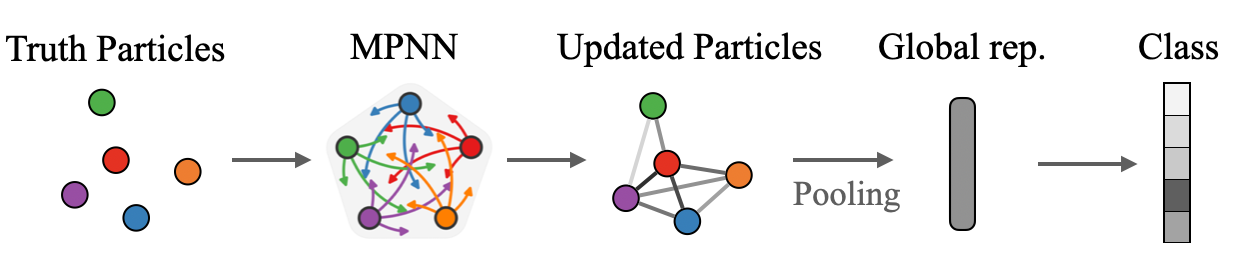

In [3]:
from IPython.display import Image, display
display(Image(filename='img/jet_gnn.png', embed=True, width=700))

#### Dataset preparation

Before we start we need to prepare a train, validation and test dataset from the files we have. Best way to do it is to load the data of all files, append the jet type as a feature, concatenate all datasets, mix them and split into 3 files.

Let's define the following labeling: 

0 - light quark q

1 - gluon g

2 - W-boson w

3 - Z-boson z

4 - top quark t

In [15]:
import h5py
import numpy as np

f_q = h5py.File('../dataset/q.hdf5', 'r')
f_g = h5py.File('../dataset/g.hdf5', 'r')
f_w = h5py.File('../dataset/w.hdf5', 'r')
f_z = h5py.File('../dataset/z.hdf5', 'r')
f_t = h5py.File('../dataset/t.hdf5', 'r')

jet_feat_q = np.array(f_q['jet_features'])
jet_feat_g = np.array(f_g['jet_features'])
jet_feat_w = np.array(f_w['jet_features'])
jet_feat_z = np.array(f_z['jet_features'])
jet_feat_t = np.array(f_t['jet_features'])

par_feat_q = np.array(f_q['particle_features'])
par_feat_g = np.array(f_g['particle_features'])
par_feat_w = np.array(f_w['particle_features'])
par_feat_z = np.array(f_z['particle_features'])
par_feat_t = np.array(f_t['particle_features'])

In [25]:
jet_feat_q = np.concatenate((jet_feat_q, np.zeros((jet_feat_q.shape[0], 1))), axis=1)
jet_feat_g = np.concatenate((jet_feat_g, np.ones((jet_feat_g.shape[0], 1))), axis=1)
jet_feat_w = np.concatenate((jet_feat_w, 2*np.ones((jet_feat_w.shape[0], 1))), axis=1)
jet_feat_z = np.concatenate((jet_feat_z, 3*np.ones((jet_feat_z.shape[0], 1))), axis=1)
jet_feat_t = np.concatenate((jet_feat_t, 4*np.ones((jet_feat_t.shape[0], 1))), axis=1)

In [26]:
jet_feat_all = np.concatenate((jet_feat_q, jet_feat_g, jet_feat_w, jet_feat_z, jet_feat_t))
par_feat_all = np.concatenate((par_feat_q, par_feat_g, par_feat_w, par_feat_z, par_feat_t))

print(jet_feat_all.shape, par_feat_all.shape)

(880000, 5) (880000, 30, 4)


In [34]:
# shuffle
mix_idx = np.random.permutation(jet_feat_all.shape[0])
jet_feat_all = jet_feat_all[mix_idx]
par_feat_all = par_feat_all[mix_idx]

In [41]:
# we have 880k jets, lets take 700k for training, 80k for validation and 100k for testing

f = h5py.File("../dataset/train.hdf5", "w")
f.create_dataset('jet_features', data=jet_feat_all[:700000])
f.create_dataset('particle_features', data=par_feat_all[:700000])
f.close()

f_ = h5py.File("../dataset/val.hdf5", "w")
f_.create_dataset('jet_features', data=jet_feat_all[700000:780000])
f_.create_dataset('particle_features', data=par_feat_all[700000:780000])
f_.close()

f_t = h5py.File("../dataset/test.hdf5", "w")
f_t.create_dataset('jet_features', data=jet_feat_all[780000:])
f_t.create_dataset('particle_features', data=par_feat_all[780000:])
f_t.close()

We will need to scale our data before giving it to the network. Usually we want our input features to have a mean of 0 and a standard deviation of 1. As the particle features are already given as relative quantities and are already between 0 and 1 there is no need to scale them. For the mass and the transverse momentum it is customary to take the logarithm before scaling as their distribution spreads over different orders of magnitude.

Use these quantities later in the dataloader.

In [64]:
# pt 
mean_pt = np.mean(np.log(jet_feat_all[:, 0]))
std_pt = np.std(np.log(jet_feat_all[:, 0]))

# eta
mean_eta = np.mean(jet_feat_all[:, 1])
std_eta = np.std(jet_feat_all[:, 1])

# mass
mean_mass = np.mean(np.log(jet_feat_all[:, 2]))
std_mass = np.std(np.log(jet_feat_all[:, 2]))


### Write the architecture

Go to `dataloader.py` and fill the sceleton for the dataloader. Check that the dataloader works by loading only a few events.

In [66]:
%load_ext autoreload
%autoreload 2

In [71]:
from dataloader_sol import JetDataset, collate_graphs
from torch.utils.data import DataLoader

In [147]:
dataset = JetDataset('../dataset/train.hdf5', n_events=40)
loader = DataLoader(dataset, batch_size=20, collate_fn=collate_graphs, shuffle=True)
# check the loader like this 
for i, data in enumerate(loader):
    if i > 0:
        break

done loading data


Now proceed to `model.py` to fill the skeleton for the GNN architecture. 

In [157]:
from model_sol import JetNet

model = JetNet()

# check the model like this
for i, data in enumerate(loader):
    out = model(data)
    break

In [158]:
# import optimizers and loss functions
import torch
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')


In [1]:
# write the training loop and check first if you can overfit a small dataset
# if you can overfit a small dataset, then you can train on the full dataset

In [ ]:
# evaluate on the test set like this, you are saving the predictions and the targets
model.eval()
preds = []
targets = []
with torch.no_grad():
    for i, data in enumerate(loader):
        out = model(data)
        pred = out.nodes['global_node'].data['pred']
        target = out.nodes['global_node'].data['class']
        # sample predictions
        pred_class = torch.multinomial(pred,1).squeeze(1)
        preds.append(pred_class)
        targets.append(target)
preds = torch.cat(preds)
targets = torch.cat(targets)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# look at the confusion matrix to analyze the performance
# ideally you want the diagonal to be as high as possible
plt.figure(figsize=(10,7))
cmap = 'Blues'
cm = confusion_matrix(preds, targets, labels=[0,1,2,3,4])
df_cm = pd.DataFrame(cm, index=['q','g','W','Z','t'], columns=['q','g','W','Z','t'])
sn.heatmap(df_cm / np.sum(df_cm), annot=True, fmt=".2%", annot_kws={"size": 15}, cmap=cmap, cbar=False)
plt.xlabel('Truth',fontsize=15) 
plt.ylabel('Pred',fontsize=15)


What other performance plots can you think of? 

Play with the network by increasing layers and dimensions, number of iteration blocks. You can also change the type of scaling (without taking the logarithm, or try no scaling at all). 


Note that the architecture is still very primitive and you probably won't reach more than ~80% accuracy for each type.


Do you expect the performance that you get? use the knowledge from part 1 to interpret your results.